In [1]:
# 지금 이미지는 ./data/src/18-40-02-02 (SLA).jpg
# label은 ./data/src/18-40-02-02 (SLA)_re_image.png 로 존재
path = 'data'

In [2]:
src_path = path+'/src/'
label_path = path+'/label/'

In [4]:
src_image = []        # src 이미지
label_image = []    # label 이미지
for i in os.listdir(src_path):
  src_image.append(src_path + i)

for i in os.listdir(label_path):
  label_image.append(label_path + i)


------------------------------------------

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

In [32]:
class Augment:
  global cols
  global rows
  global channels
  
  def __init__(self, img, mask):
    """
    args:
      img : 지금은 image 경로. 추후에는 directory로 변경할 수 있음.
      mask : 지금은 label 경로. 추후에는 directory로 변경할 수 있음.
    instances:
      self.img : OpenCV로 읽어온 image
      self.mask : OpenCV로 읽어온 label
      self.rows : image의 rows
      self.cols : image의 cols
      self.channels : image의 channels
      self.temp : image와 mask가 합쳐진 numpy array
    """
    self.img = cv2.imread(img, cv2.IMREAD_UNCHANGED)
    self.mask = cv2.imread(mask, cv2.IMREAD_UNCHANGED)
    self.rows = None
    self.cols = None
    self.channels = None
    self.temp = None

  def image_mask(self, img, mask, color=0): # image와 mask 비교 후 조건에 맞으면 합치기
    """
    image와 mask를 비교 후 조건에 맞으면 합쳐준다. (image와 mask에 동일한 변환을 주기 위해)
    args:
      img : OpenCV로 읽어온 image
      mask : OpenCV로 읽어온 label
      color : image를 변환할 color. 0 = 원래 이미지 color, 1 = grayscale, 2 = BGR [default=0]
    returns:
      temp : image와 mask가 합쳐진 numpy array
    """
    if img.shape[:2] != mask.shape[:2]: # image 와 mask의 rows, cols의 크기는 같아야함.
      print(f"Image and mask's shape[:2] must be equal. Your image.shape[:2] = {img.shape[:2]}, and mask.shape = {mask.shape[:2]}")
      return None
    # rows, cols 을 구함
    if img.ndim == 2:
        self.rows, self.cols = img.shape
        self.channels = 1
    elif img.ndim == 3:
        self.rows, self.cols, self.channels = img.shape
    else:
        print(f"Image's ndim must be 2 or 3. Your input image's ndim is {img.ndim}")
        return None

    # image 색 변환
    if color == 0: # 그대로
      pass
    elif color == 1: # grayscale
      if self.channels == 1:
        print('Input image is already grayscale')
        pass
      elif self.channels == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      elif self.channels == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
      else:
        print(f'Maybe there is problem. self.channels = {self.channels}')
      self.channels = 1
    elif color == 2: # BGR
      if self.channels == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
      elif self.channels == 3:
        print('Input image is already BGR')
        pass
      elif self.channels == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
      else:
        print(f'Maybe there is problem. self.channels = {self.channels}')
      self.channels = 3
    else:
      print(f'Color option must be 0, 1 or 2. Your color option = {color}')


    # image와 mask의 channel이 다를 경우 (ex: image는 3채널 rgb인데 mask는 grayscale일 경우)
    if img.shape != mask.shape:
        if img.ndim == 2:
            img = img.reshape((img.shape[0], img.shape[1], 1))
        elif mask.ndim == 2:
            mask = mask.reshape((mask.shape[0], mask.shape[1], 1))
        else:
            print(f'Maybe there is problem. img.shape = {img.shape}, mask.shape = {mask.shape}')
            return None
    else:
        if img.ndim == 2: # 둘 다 channel이 1일 경우 dimension을 추가해주어야 concate 후 분리 가능
            img = img.reshape((img.shape[0], img.shape[1], 1))
            mask = mask.reshape((mask.shape[0], mask.shape[1], 1))

    temp = np.concatenate((img, mask), axis=-1) # img와 mask를 합친 후 한 번에 수행
    self.temp = temp
    return temp

  def translation(self, temp, x_range, y_range, control=True):
    """
    x축은 -x_range ~ x_range, y축은 -y_range ~ y_range의 범위에서 랜덤한 값으로 이미지를 이동시켜준다.
    args:
      temp : image와 mask가 합쳐진 numpy array
      x_range : x축 방향으로 이동시킬 범위
      y_range : y축 방향으로 이동시킬 범위
      control : translation을 진행할 것인지에 대한 boolean 값. True면 진행 False면 진행 X [default=True]
    returns:
      ret_img : 변환된 image
      ret_mask : 변환된 mask
    """
    if control:
      x_range = np.abs(x_range)
      y_range = np.abs(y_range)
      x = random.randint(-x_range, x_range) # 지정한 범위 내 random한 값
      y = random.randint(-y_range, y_range) # 지정한 범위 내 random한 값

      # translation matrix
      M = np.float32([[1,0,x],
                      [0,1,y]])
      ret = cv2.warpAffine(temp, M, (self.cols, self.rows)) # translation
      ret_img = ret[:,:,:self.channels] # 변환된 img
      ret_mask = ret[:,:,self.channels:] # 변환된 mask
      return ret_img, ret_mask


  def rotation(self, temp, degree, center=0, control=True):
    """
    -degree ~ degree 각도의 범위 내에서 랜덤한 값으로 회전 시켜준다.
    이때, 중심은 이미지의 중심에서 각 x, y축의 -center ~ center 범위의 랜덤한 위치이다. 
    args:
      temp : image와 mask가 합쳐진 numpy array
      degree : 회전시킬 각도 범위
      center : 회전시킬 중심의 범위. 0이면 image의 중심. [default=0]
      control : rotation을 진행할 것인지에 대한 boolean 값. True면 진행 False면 진행 X [default=True]
    returns:
      ret_img : 변환된 image
      ret_mask : 변환된 mask
    """
    if control:
      center = np.abs(center)
      degree = np.abs(degree)
      if center != 0: # 회전 중심 위치
          center_x = random.randint(-center, center)
          center_y = random.randint(-center, center)
      else:
          center_x = 0
          center_y = 0

      degree_ = random.randint(-degree, degree)
      M = cv2.getRotationMatrix2D((self.cols/2 + center_x, self.rows/2 + center_y), degree_, 1) # rotaion matrix

      ret = cv2.warpAffine(temp, M, (self.cols, self.rows)) # rotaion
      ret_img = ret[:,:,:self.channels] # 변환된 img
      ret_mask = ret[:,:,self.channels:] # 변환된 mask
      return ret_img, ret_mask

  def flip(self, temp, control=True):
    """
    이미지를 위 아래로 반전
    args:
      temp : image와 mask가 합쳐진 numpy array
      control : flip을 진행할 것인지에 대한 boolean 값. True면 진행 False면 진행 X [default=True]
    returns:
      ret_img : 변환된 image
      ret_mask : 변환된 mask
    """
    if control:
      ret = cv2.flip(temp, 0)
      ret_img = ret[:,:,:self.channels] # 변환된 img
      ret_mask = ret[:,:,self.channels:] # 변환된 mask
      return ret_img, ret_mask  
    
  def mirror(self, temp, control=True):
    """
    이미지를 좌우로 반전
    args:
      temp : image와 mask가 합쳐진 numpy array
      control : mirror을 진행할 것인지에 대한 boolean 값. True면 진행 False면 진행 X [default=True]
    returns:
      ret_img : 변환된 image
      ret_mask : 변환된 mask
    """
    if control:
      ret = cv2.flip(temp, 1)
      ret_img = ret[:,:,:self.channels] # 변환된 img
      ret_mask = ret[:,:,self.channels:] # 변환된 mask
      return ret_img, ret_mask

  def run(self, x_range=None, y_range=None, trans=True, degree=30, center=0, rotate=True, flip=True, mirror=True, color=0):
    """
    args:
      x_range : x축 방향으로 이동시킬 범위 [default=int(self.cols / 4)]
      y_range : y축 방향으로 이동시킬 범위 [default=int(self.rows / 4)]
      trans : translation을 진행할 것인지에 대한 boolean 값. True면 진행 False면 진행 X [default=True]
      degree : 회전시킬 각도 범위 [default=30]
      center : 회전시킬 중심의 범위. 0이면 image의 중심. [default=0]
      rotate : rotation을 진행할 것인지에 대한 boolean 값. True면 진행 False면 진행 X [default=True]
      flip : flip을 진행할 것인지에 대한 boolean 값. True면 진행 False면 진행 X [default=True]
      mirror : mirror을 진행할 것인지에 대한 boolean 값. True면 진행 False면 진행 X [default=True]
      color : image를 변환할 color. 0 = 원래 이미지 color, 1 = grayscale, 2 = BGR [default=0]
    """
    self.temp = self.image_mask(self.img, self.mask, color=color)
    if x_range is None:
      x_range = int(self.cols / 4)
    if y_range is None:
      y_range = int(self.rows / 4)
    trans_img, trans_label = self.translation(self.temp, x_range, y_range, trans)
    rotate_img, rotate_label = self.rotation(self.temp, degree, center, rotate)
    flip_img, flip_label = self.flip(self.temp, flip)
    mirror_img, mirror_label = self.mirror(self.temp, mirror)
    return trans_img, trans_label, rotate_img, rotate_label, flip_img, flip_label, mirror_img, mirror_label


In [33]:
def plot_imgs(img, mask, a, b, c, d, e, f, g, h): 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
  a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  b = cv2.cvtColor(b, cv2.COLOR_BGR2RGB)
  c = cv2.cvtColor(c, cv2.COLOR_BGR2RGB)
  d = cv2.cvtColor(d, cv2.COLOR_BGR2RGB)
  e = cv2.cvtColor(e, cv2.COLOR_BGR2RGB)
  f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
  g = cv2.cvtColor(g, cv2.COLOR_BGR2RGB)
  h = cv2.cvtColor(h, cv2.COLOR_BGR2RGB)

  plt.figure(figsize=(10,40))
  plt.subplot(10,2,1)
  plt.imshow(img) 
  plt.title('Orig Img')
  plt.subplot(10,2,2)
  plt.imshow(mask)
  plt.title('Orig label')

  plt.subplot(10,2,3)
  plt.imshow(a)
  plt.title('translation Img')
  plt.subplot(10,2,4)
  plt.imshow(b)
  plt.title('translation label')

  plt.subplot(10,2,5)
  plt.imshow(c)
  plt.title('rotation Img')
  plt.subplot(10,2,6)
  plt.imshow(d)
  plt.title('rotation label')
  
  plt.subplot(10,2,7)
  plt.imshow(e)
  plt.title('flip Img')
  plt.subplot(10,2,8)
  plt.imshow(f)
  plt.title('flip label')

  plt.subplot(10,2,9)
  plt.imshow(g)
  plt.title('mirror Img')
  plt.subplot(10,2,10)
  plt.imshow(h)
  plt.title('mirror label')

  plt.show()

In [34]:
src_image, label_image

(['data/src/18-40-02-02 (SLA).jpg'],
 ['data/label/18-40-02-02 (SLA)_re_image.png'])

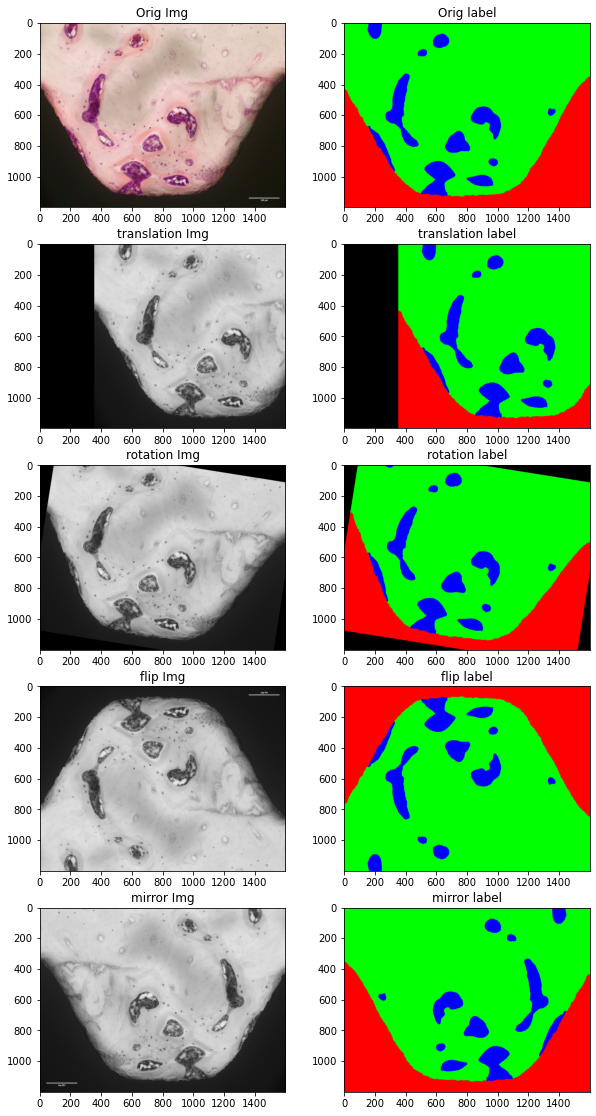

In [35]:
for src, label in zip(src_image, label_image):
    a = Augment(src, label)
    trans_img, trans_label, rotate_img, rotate_label, flip_img, flip_label, mirror_img, mirror_label = a.run(degree=100, center=50, color=1)
    plot_imgs(a.img, a.mask, trans_img, trans_label, rotate_img, rotate_label, flip_img, flip_label, mirror_img, mirror_label)

1. 각 변수들을 클래스 인스턴스 형태로 해봤고, run 함수를 클래스 내부 함수로 넣어봤어요. 그래서 나중에 csv로 받은 값들을 run 함수의 arguments로 넣어주어서 설정 값들을 정해주는 형태로 하면 될 것 같아요.
2. 클래스에서는 지금은 파일명 하나씩을 받아와서 했는데 만약에 데이터가 여러장이라면 위에 제가 한 것 처럼 클래스 밖에서 실행할 때 for 문으로 해도 되고, 아예 클래스에서 directory를 arguments로 받아서 처리해도 될 것 같아요.
3. 지금은 실행하고 이미지를 return 해주는데, 나중에는 cv2.imwrite()로 저장하는 형태로 바꾸면 될 것 같아요.
4. control 변수는 실행을 할 것인지 안 할 것인지에 대한 변수로 생각해서 boolean 형태로 바꿔 주었고, 그래서 flip과 mirror는 분리 해놓았습니다.
5. rotation이나 translation을 하고나서 비는 부분 padding 줄 건지 옵션 추가하면 좋을 듯 합니다.
6. 컬러 모드 변경하는 기능 추가 해놓았습니다.
7. 또 다른 기능들 추가하면 될 것 같아요. Histogram Equalization 이라던지, 밝기를 전체적으로 올린다던지 내린다던지 등등 !